# Задание 6. Исполнитель: Сафиуллин Роберт
Просэмплировать варианты нейросетей по сетке, сделать 3d-график, каждая точка которого соответствует модели, а координаты:
* Количество параметров нейросети
* Точность модели
* Время обработки одного батча.
	
Построить графики с использованием CPU и GPU. 	
На графике также отметить парето-оптимальный фронт. Допускается использование логарифмической шкалы для наглядности.

**Сетка нейросетей**: сверточные нейросети

**Выборка**: Fasion-MNIST.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from torch.autograd import Variable




In [2]:
class FashionCNN(nn.Module):
          def __init__(self, fc1_params, fc2_params, conv2_params):
            super(FashionCNN, self).__init__()
            
            self.layer1 = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            
            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=param3, kernel_size=3),
                nn.BatchNorm2d(conv2_params),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            
            self.fc1 = nn.Linear(in_features=param3*6*6, out_features=fc1_params)
            self.drop = nn.Dropout2d(0.25)
            self.fc2 = nn.Linear(in_features=fc1_params, out_features=fc2_params)
            self.fc3 = nn.Linear(in_features=fc2_params, out_features=10)
          
          def forward(self, x):
              out = self.layer1(x)
              out = self.layer2(out)
              out = out.view(out.size(0), -1)
              out = self.fc1(out)
              out = self.drop(out)
              out = self.fc2(out)
              out = self.fc3(out)
          
              return out   
            
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
# Pareto
def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row) 



### Fashion-MNIST

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512


train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  


train_set = torch.utils.data.Subset(train_set,list(range(0, len(train_set), 4)))
test_set = torch.utils.data.Subset(test_set,list(range(0, len(test_set), 4)))

trainloader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size)






  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



9


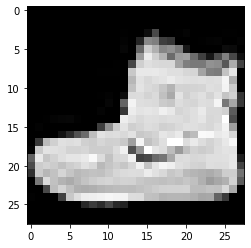

In [4]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

### Сетка параметров

In [10]:

paramset = [[8, 8, 16],
 [8, 8, 32],
 [8, 8, 64],
 [8, 8, 128],
 [8, 8, 256],
 [8, 8, 512],
 [8, 16, 16],
 [8, 16, 32],
 [8, 16, 64],
 [8, 16, 128],
 [8, 16, 256],
 [8, 16, 512],
 [8, 32, 32],
 [8, 32, 64],
 [8, 32, 128],
 [8, 32, 256],
 [8, 32, 512],
 [8, 64, 64],
 [8, 64, 128],
 [8, 64, 256],
 [8, 64, 512],
 [8, 128, 128],
 [8, 128, 256],
 [8, 128, 512],
 [8, 256, 256],
 [8, 256, 512],
 [8, 512, 512],
 [16, 16, 16],
 [16, 16, 32],
 [16, 16, 64],
 [16, 16, 128],
 [16, 16, 256],
 [16, 16, 512],
 [16, 32, 32],
 [16, 32, 64],
 [16, 32, 128],
 [16, 32, 256],
 [16, 32, 512],
 [16, 64, 64],
 [16, 64, 128],
 [16, 64, 256],
 [16, 64, 512],
 [16, 128, 128],
 [16, 128, 256],
 [16, 128, 512],
 [16, 256, 256],
 [16, 256, 512],
 [16, 512, 512],
 [32, 32, 32],
 [32, 32, 64],
 [32, 32, 128],
 [32, 32, 256],
 [32, 32, 512],
 [32, 64, 64],
 [32, 64, 128],
 [32, 64, 256],
 [32, 64, 512],
 [32, 128, 128],
 [32, 128, 256],
 [32, 128, 512],
 [32, 256, 256],
 [32, 256, 512],
 [32, 512, 512],
 [64, 64, 64],
 [64, 64, 128],
 [64, 64, 256],
 [64, 64, 512],
 [64, 128, 128],
 [64, 128, 256],
 [64, 128, 512],
 [64, 256, 256],
 [64, 256, 512],
 [64, 512, 512],
 [128, 128, 128],
 [128, 128, 256],
 [128, 128, 512],
 [128, 256, 256],
 [128, 256, 512],
 [128, 512, 512],
 [256, 256, 256],
 [256, 256, 512],
 [256, 512, 512],
 [512, 512, 512]]

### GPU

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accs_gpu = []
number_of_params_gpu = []
mean_times_gpu = []
for params in paramset:
      
      param1,param2,param3 = params
      net = FashionCNN(param1,param2,param3).to(device)
      number_of_params_gpu.append(count_parameters(net))
      criterion = nn.CrossEntropyLoss()
      learning_rate = 0.001
      optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
      times = []
      for epoch in range(2):  # loop over the dataset multiple times

          for images, labels in (trainloader):
              
              t0 = time.time()
              # get the inputs; data is a list of [inputs, labels]
              images, labels = images.to(device), labels.to(device)
              train = Variable(images.view(len(images), 1, 28, 28))
              labels = Variable(labels)
              # zero the parameter gradients
              
              optimizer.zero_grad()
              # forward + backward + optimize
              outputs = net(train)
              loss = criterion(outputs, labels)
              
              loss.backward()
              optimizer.step()

              times.append(time.time() - t0)
        

      correct = 0
      total = 0
          # since we're not training, we don't need to calculate the gradients for our outputs
      with torch.no_grad():
              for data in testloader:
                  images, labels = data
                  images, labels = images.to(device), labels.to(device)
                  # calculate outputs by running images through the network
                  outputs = net(images)
                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

              print(f'Accuracy: {100 * correct // total} %')
              accs_gpu.append(100 * correct // total)
              mean_times_gpu.append(np.mean(times))


### Для удобства подсчета Парето фронта был взят отрицательный логарифм параметров и отрицательное время, т.е. чем больше, тем лучше.

In [43]:

inputPoints = (np.vstack(([ -x for x in np.log(number_of_params_gpu)],[ -x for x in (mean_times_gpu)] , accs_gpu)).T).tolist()
paretoPoints, dominatedPoints = simple_cull(inputPoints, dominates)
paretoPoints = (np.array(list(paretoPoints)))
dominatedPoints = np.array(list(dominatedPoints))
df_gpu = pd.DataFrame(np.vstack((paretoPoints,dominatedPoints)), columns = ['neg Params','neg Time','Accuracy'])
df_gpu['pareto'] = np.vstack((np.ones_like(paretoPoints),np.zeros_like(dominatedPoints)))[:,0]




### CPU

In [13]:

device = torch.device("cpu")
accs_cpu = []
number_of_params_cpu = []
mean_times_cpu = []
for params in paramset:

      param1,param2,param3 = params
      net = FashionCNN(param1,param2,param3).to(device)
      number_of_params_cpu.append(count_parameters(net))
      criterion = nn.CrossEntropyLoss()
      learning_rate = 0.001
      optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
      times = []
      for epoch in range(2):  # loop over the dataset multiple times

          for images, labels in (trainloader):
              
              t0 = time.time()
              # get the inputs; data is a list of [inputs, labels]
              images, labels = images.to(device), labels.to(device)
              train = Variable(images.view(len(images), 1, 28, 28))
              labels = Variable(labels)
              # zero the parameter gradients
              
              optimizer.zero_grad()
              # forward + backward + optimize
              outputs = net(train)
              loss = criterion(outputs, labels)
              
              loss.backward()
              optimizer.step()

              times.append(time.time() - t0)
        

      correct = 0
      total = 0
          # since we're not training, we don't need to calculate the gradients for our outputs
      with torch.no_grad():
              for data in testloader:
                  images, labels = data
                  images, labels = images.to(device), labels.to(device)
                  # calculate outputs by running images through the network
                  outputs = net(images)
                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

              print(f'Accuracy: {100 * correct // total} %')
              accs_cpu.append(100 * correct // total)
              mean_times_cpu.append(np.mean(times))


Accuracy: 82 %
Accuracy: 82 %
Accuracy: 82 %
Accuracy: 81 %
Accuracy: 82 %
Accuracy: 81 %
Accuracy: 83 %
Accuracy: 81 %


In [42]:
inputPoints = (np.vstack(([ -x for x in np.log(number_of_params_cpu)],[ -x for x in (mean_times_cpu)] , accs_cpu)).T).tolist()
paretoPoints, dominatedPoints = simple_cull(inputPoints, dominates)
paretoPoints = (np.array(list(paretoPoints)))
dominatedPoints = np.array(list(dominatedPoints))
df_cpu = pd.DataFrame(np.vstack((paretoPoints,dominatedPoints)), columns = ['neg Params','neg Time','Accuracy'])
df_cpu['pareto'] = np.vstack((np.ones_like(paretoPoints),np.zeros_like(dominatedPoints)))[:,0]



### Pareto front

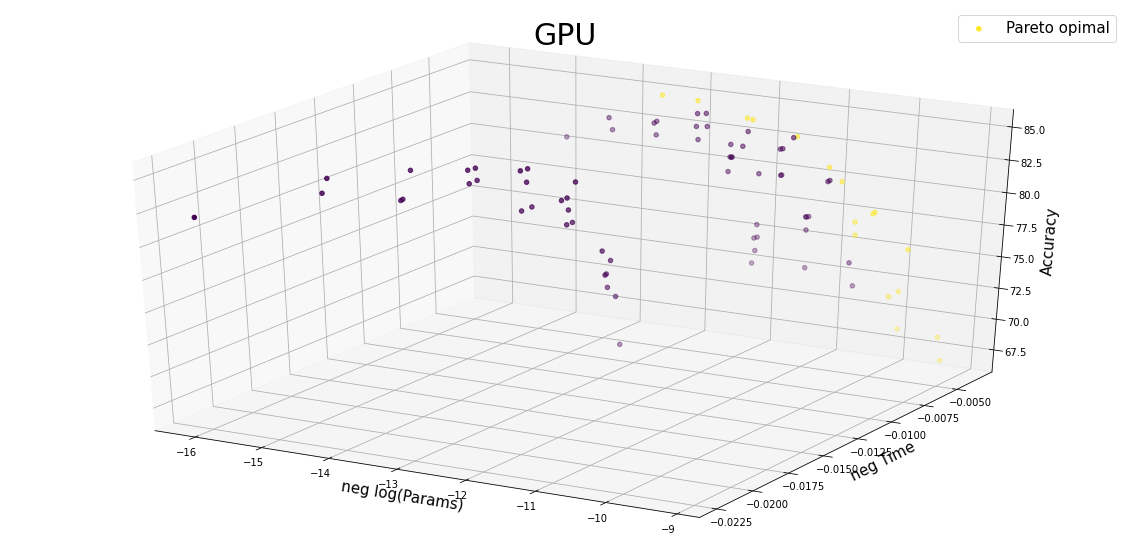

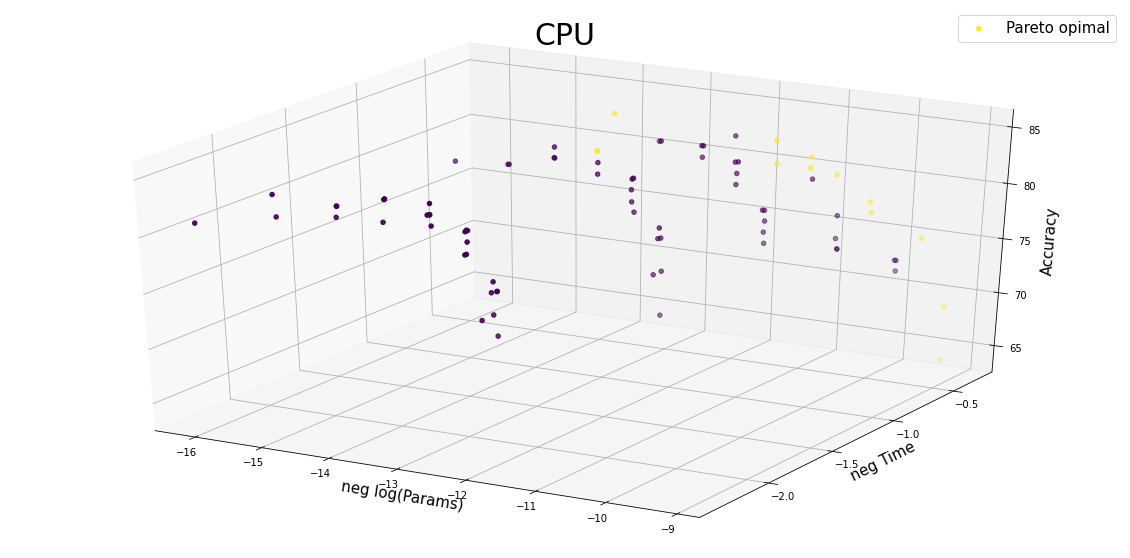

In [49]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_gpu['neg Params'], df_gpu['neg Time'], df_gpu['Accuracy'], c = df_gpu['pareto'])
ax.set_xlabel('neg log(Params)', fontsize = 15)
ax.set_ylabel('neg Time', fontsize = 15)
ax.set_zlabel('Accuracy', fontsize = 15)
ax.set_title('GPU', fontsize = 30)
ax.legend(labels = ['Pareto opimal'], fontsize = 15)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_cpu['neg Params'], df_cpu['neg Time'], df_cpu['Accuracy'], c = df_cpu['pareto'])
ax.set_xlabel('neg log(Params)', fontsize = 15)
ax.set_ylabel('neg Time', fontsize = 15)
ax.set_zlabel('Accuracy', fontsize = 15)
ax.set_title('CPU', fontsize = 30)
ax.legend(labels = ['Pareto opimal'], fontsize = 15)


### Покрутить:

In [52]:
fig = px.scatter_3d(df_cpu, x='neg Params', y='neg Time', z='Accuracy',
                    color='pareto',title = 'CPU')
fig.show()

fig = px.scatter_3d(df_gpu, x='neg Params', y='neg Time', z='Accuracy',
                    color='pareto', title = 'GPU')
fig.show()

### Из заметных отличий - время обработки на GPU значительно меньше чем на CPU. В обоих случаях получаем, что наиболее выгодными являются модели с наименьшим временем обработки батча.